In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("air_passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index("Month")
df

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


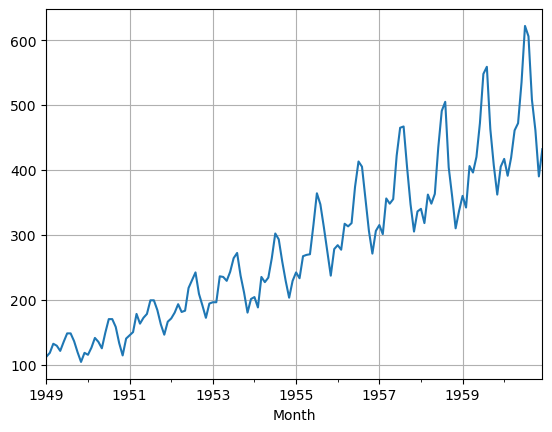

In [3]:
df['#Passengers'].plot()
plt.grid()
plt.show()

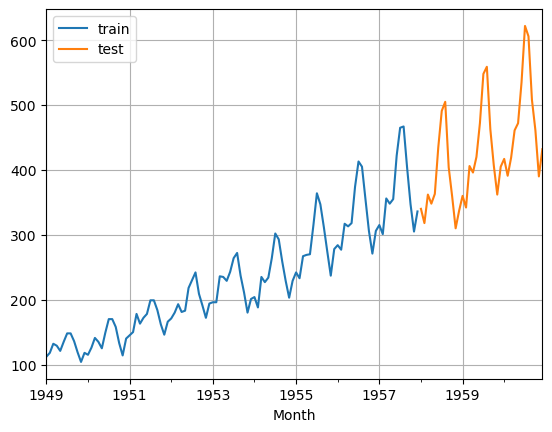

In [4]:
# 시계열(train_test_split) // 데이터 누수.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, shuffle=False)

train['#Passengers'].plot()
test['#Passengers'].plot()
plt.legend(['train', 'test'])
plt.grid()
plt.show()

In [5]:
# year = 1960
# train = df[df.index.year < year]
# test = df[df.index.year >= year]

# Naive 예측 모형
Naive 예측 모형은 이름 그대로 "가장 단순하고 직관적인" 시계열 예측 방법입니다. 복잡한 계산 없이 "바로 이전 시점의 값이 다음 시점에도 그대로 유지될 것"이라고 예측하는 방식이죠.

* 매우 간단한 예측: 복잡한 모델을 만들기 전에 가장 기본적인 예측 성능을 확인하고 싶을 때 사용합니다.
* 비교 기준(Baseline): 다른 복잡한 예측 모델의 성능이 Naive 모델보다 얼마나 더 좋은지 비교하기 위한 기준으로 사용됩니다. 만약 새로 만든 모델이 Naive 모델보다 성능이 좋지 않다면, 그 모델은 별로 유용하지 않다고 판단할 수 있습니다.
* 데이터 패턴이 거의 없을 때: 데이터가 무작위적으로 변동하거나(Random Walk), 뚜렷한 추세나 계절성이 없을 때 의외로 괜찮은 성능을 보이기도 합니다.

```예측값(t+1) = α * 실제값(t) + (1 - α) * 예측값(t)```

In [6]:
data = {
    'Date': pd.to_datetime(['2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01']),
    'Sales': [100, 110, 105, 120, 115, 125] # 실제 판매량
}
df = pd.DataFrame(data)
df = df.set_index('Date') # 날짜를 인덱스로 설정
df

,Sales
Date,
2024-01-01,100
2024-02-01,110
2024-03-01,105
2024-04-01,120
2024-05-01,115
2024-06-01,125


In [7]:
df["Pred"] = df['Sales'].shift(1)
df

,Sales,Pred
Date,,
2024-01-01,100,NaN
2024-02-01,110,100.0
2024-03-01,105,110.0
2024-04-01,120,105.0
2024-05-01,115,120.0
2024-06-01,125,115.0


In [8]:
df['Sales'].iloc[-1]

125

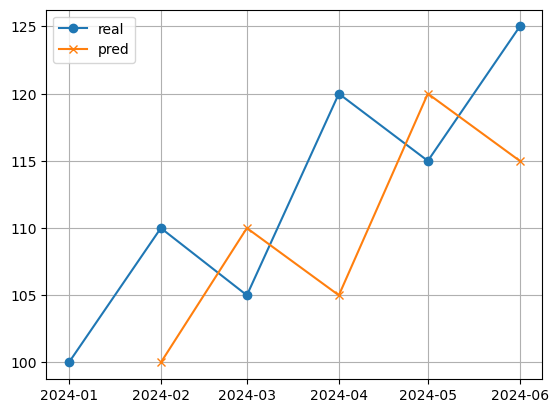

In [9]:
plt.plot(df.index, df['Sales'], marker = 'o')
plt.plot(df.index, df['Pred'], marker = 'x')
plt.legend(["real", "pred"])
plt.grid()
plt.show()

In [10]:
from darts.models import NaiveSeasonal
from darts import TimeSeries

df = pd.read_csv("air_passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index("Month")

train, test = train_test_split(df, shuffle=False)

df_ts = TimeSeries.from_dataframe(df, value_cols=['#Passengers'])
train_ts = TimeSeries.from_dataframe(train, value_cols=['#Passengers'])
test_ts = TimeSeries.from_dataframe(test, value_cols=['#Passengers'])

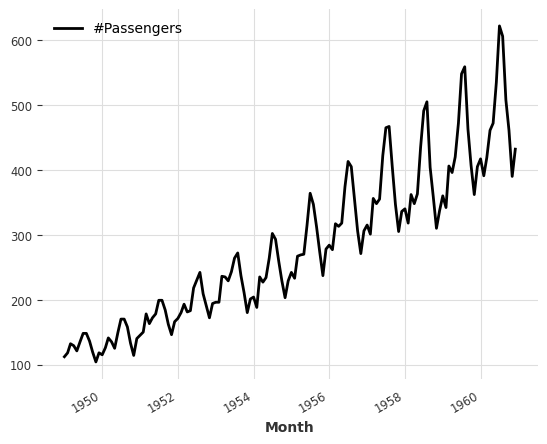

In [11]:
df_ts.plot()
plt.show()

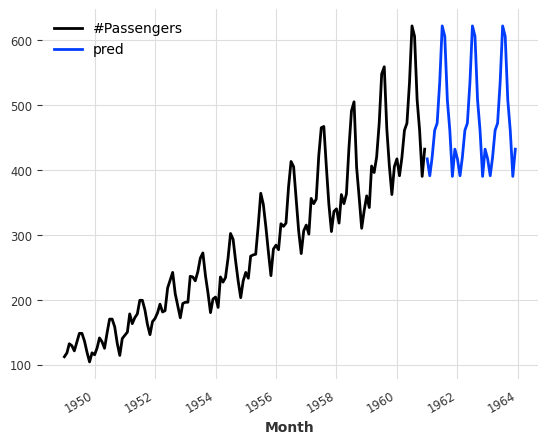

In [16]:
model = NaiveSeasonal(K=12)
model.fit(df_ts)

pred = model.predict(36) # 앞에 값을 활용해서 36개를 예측해라.

df_ts.plot()
pred.plot(label = "pred")
plt.show()

# 지수 평활법 (Exponential Smoothing) 예측 모형
지수 평활법(Exponential Smoothing)은 Naive 예측 모형보다 조금 더 발전된 시계열 예측 방법입니다. Naive 모형이 오직 '바로 이전' 값만 사용했던 것과 달리, 지수 평활법은 과거의 모든 관측값을 사용하되, 최근 값에 더 많은 가중치를 두어 예측합니다. 마치 시간이 지날수록 과거 정보의 중요도가 지수적으로(exponentially) 감소하는 것과 같다고 해서 이런 이름이 붙었습니다.

* 최근 데이터일수록 더 높은 가중치를 받고, 오래된 데이터일수록 낮은 가중치를 받는다.
* 비교적 구현이 간단하면서도 과거 데이터를 반영하므로 단기 예측에 자주 사용됩니다.

In [18]:
data = {
    'Date': pd.to_datetime(['2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01']),
    'Sales': [100, 110, 105, 120, 115, 125] # 실제 판매량
}
df = pd.DataFrame(data)
df = df.set_index('Date') # 날짜를 인덱스로 설정
df

,Sales
Date,
2024-01-01,100
2024-02-01,110
2024-03-01,105
2024-04-01,120
2024-05-01,115
2024-06-01,125


In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
warnings.filterwarnings("ignore")

model = SimpleExpSmoothing(df['Sales'])
fit_model = model.fit(smoothing_level=0.8)
df["Pred"] = fit_model.fittedvalues
fit_model.forecast(1)

2024-07-01    123.0848
Freq: MS, dtype: float64

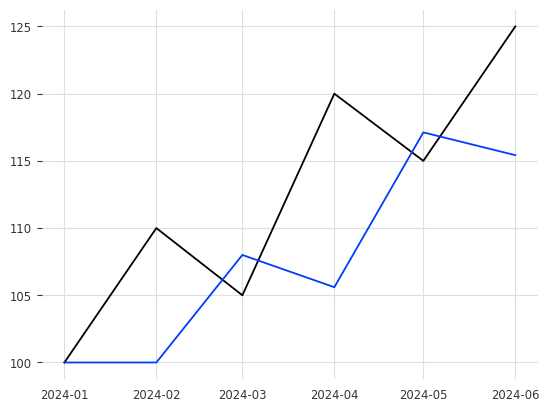

In [28]:
plt.plot(df.index, df['Sales'])
plt.plot(df.index, df['Pred'])
plt.show()

In [29]:
df = pd.read_csv("air_passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index("Month")

train, test = train_test_split(df, shuffle=False)

df_ts = TimeSeries.from_dataframe(df, value_cols=['#Passengers'])
train_ts = TimeSeries.from_dataframe(train, value_cols=['#Passengers'])
test_ts = TimeSeries.from_dataframe(test, value_cols=['#Passengers'])

In [31]:
from darts.models import ExponentialSmoothing
model = ExponentialSmoothing()
model.fit(df_ts)
pred = model.predict(10)
pred.values()

array([[451.57721717],
       [427.25771105],
       [464.69885083],
       [500.10304476],
       [508.66066614],
       [567.71378046],
       [647.89723984],
       [632.46096996],
       [534.3742948 ],
       [484.93102452]])

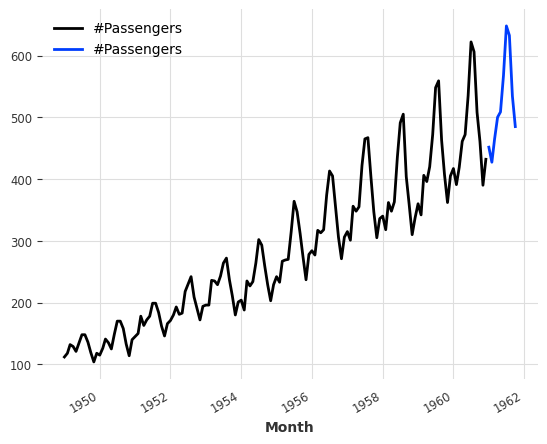

In [33]:
df_ts.plot()
pred.plot()
plt.show()

# ETS 모형: 오차, 추세, 계절성을 모두 고려하는 예측
ETS는 ```Error (오차), Trend (추세), Seasonality (계절성)```의 약자로, 시계열 데이터를 이 세 가지 주요 구성 요소로 분해하여 모델링하는 강력한 예측 방법론입니다. 이전에 설명드렸던 지수 평활법(Exponential Smoothing) 모델들은 사실 이 ETS 프레임워크에 속하는 특정 모델들이라고 볼 수 있습니다. 시계열 데이터는 수준(Level), 추세(Trend), 계절성(Seasonality), 그리고 예측할 수 없는 오차(Error) 요소로 구성되어 있다고 가정합니다.

```
ETS(A, N, N): 덧셈 오차(A), 추세 없음(N), 계절성 없음(N) -> 단순 지수 평활과 유사
ETS(A, A, N): 덧셈 오차(A), 덧셈 추세(A), 계절성 없음(N) -> Holt의 선형 추세 모델과 유사
ETS(A, A, A): 덧셈 오차(A), 덧셈 추세(A), 덧셈 계절성(A) -> Holt-Winters의 덧셈 계절성 모델과 유사
ETS(M, A, M): 곱셈 오차(M), 덧셈 추세(A), 곱셈 계절성(M) -> Holt-Winters의 곱셈 계절성 모델과 유사
```

* 추세나 계절성이 뚜렷한 데이터: ETS는 이러한 패턴을 명시적으로 모델링하므로 매우 효과적입니다.
* 자동 모델 선택 기능 활용: 어떤 ETS 조합(예: ETS(A,A,N) vs ETS(M,A,M))이 데이터에 가장 적합한지 자동으로 찾아주는 기능을 활용하고 싶을 때 유용합니다. (라이브러리가 AIC, BIC 같은 정보 기준을 사용해 최적 모델을 선택)
* 통계적으로 견고한 예측: ETS는 상태 공간(State Space) 모델 프레임워크를 기반으로 하여 통계적 이론이 탄탄하고, 예측 구간(prediction intervals) 계산 등 다양한 분석 기능을 제공합니다.

In [34]:
df = pd.read_csv("air_passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index("Month")

train, test = train_test_split(df, shuffle=False)

df_ts = TimeSeries.from_dataframe(df, value_cols=['#Passengers'])
train_ts = TimeSeries.from_dataframe(train, value_cols=['#Passengers'])
test_ts = TimeSeries.from_dataframe(test, value_cols=['#Passengers'])

from darts.utils.timeseries_generation import datetime_attribute_timeseries
future_cov = datetime_attribute_timeseries(df_ts, 
                                           "month", 
                                           cyclic=True, 
                                           add_length=10)

In [35]:
from darts.models import StatsForecastAutoETS
model = StatsForecastAutoETS(season_length=12, model = 'ZZZ')
model.fit(df_ts, future_covariates=future_cov)

StatsForecastAutoETS(add_encoders=None, season_length=12, model=ZZZ)

In [36]:
pred = model.predict(10, future_covariates=future_cov)
pred.values()

array([[441.40323676],
       [415.09871431],
       [448.90785391],
       [491.38584654],
       [493.11817462],
       [549.88974472],
       [628.53512698],
       [607.94839532],
       [509.75942134],
       [459.03749245]])

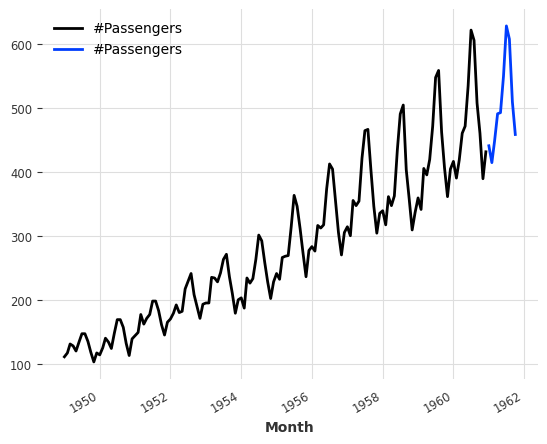

In [37]:
df_ts.plot()
pred.plot()
plt.show()

<Axes: xlabel='Month'>

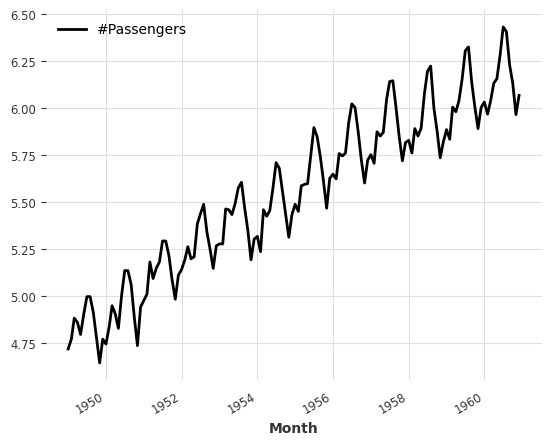

In [41]:
# log값
import numpy as np
df_ts.map(np.log).plot()

# ARIMA 모형: 시계열 데이터의 패턴을 학습하는 전통 강자
ARIMA는 AutoRegressive Integrated Moving Average의 약자로, 시계열 예측 분야에서 가장 기본적이면서도 널리 사용되는 통계적 모델 중 하나입니다. 우리말로는 자기회귀 누적 이동평균 모델이라고 부릅니다. ARIMA 모델은 시계열 데이터가 과거 자신의 값과 과거의 예측 오차에 의해 설명될 수 있다는 아이디어에 기반합니다. 즉, 데이터의 "기억" 또는 "관성"을 모델링하는 것입니다. 모델 이름에 각 구성 요소의 의미가 담겨 있습니다.

* AR (AutoRegressive) - 자기회귀 (p): 현재 시점의 데이터가 과거 p개 시점의 데이터에 영향을 받는다는 의미입니다. 예를 들어 오늘의 주가가 어제와 그저께 주가에 영향을 받는 관계를 모델링합니다. p는 참조할 과거 데이터의 시점 개수 (AR 차수)입니다.
* I (Integrated) - 누적 (d): 많은 시계열 데이터는 시간이 지남에 따라 평균이나 분산이 변하는 ```비정상성(Non-stationarity)```을 가집니다 (예: 꾸준히 증가하는 매출). ARIMA는 이 비정상성을 해결하기 위해 ```차분(Differencing)```이라는 과정을 사용합니다. 차분은 현재 시점의 데이터에서 이전 시점의 데이터를 빼는 것(데이터(t) - 데이터(t-1))으로, 보통 추세(Trend)를 제거하여 데이터를 정상성(Stationarity) 데이터로 변환하는 데 도움을 줍니다. d는 정상성을 만족하기 위해 필요한 차분의 횟수입니다. (보통 0, 1, 2 정도 사용)
* MA (Moving Average) - 이동평균 (q): 현재 시점의 데이터가 과거 q개 시점의 **예측 오차(Error)**에 영향을 받는다는 의미입니다. 즉, 과거에 예측이 얼마나 틀렸는지가 현재 값에 영향을 준다는 개념입니다. q는 참조할 과거 예측 오차의 시점 개수 (MA 차수)입니다.

이 세 가지 요소를 조합하여 ARIMA(p, d, q) 형태로 모델을 표현합니다. 예를 들어 ARIMA(1, 1, 0)은 AR(1) 모델을 1차 차분한 데이터에 적용하고, MA(0) 모델을 사용하는 것을 의미합니다.

In [38]:
df = pd.read_csv("air_passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index("Month")

train, test = train_test_split(df, shuffle=False)

df_ts = TimeSeries.from_dataframe(df, value_cols=['#Passengers'])
train_ts = TimeSeries.from_dataframe(train, value_cols=['#Passengers'])
test_ts = TimeSeries.from_dataframe(test, value_cols=['#Passengers'])

from darts.utils.timeseries_generation import datetime_attribute_timeseries
future_cov = datetime_attribute_timeseries(df_ts, 
                                           "month", 
                                           cyclic=True, 
                                           add_length=10)

In [42]:
# p = 5: 비계절성 자기회귀(AR) 차수. 현재 값 예측에 과거 5개 시점의 데이터 값을 사용합니다.
# d = 1: 비계절성 차분(I) 횟수. 데이터의 추세를 제거하기 위해 1차 차분을 수행합니다.
# q = 2: 비계절성 이동평균(MA) 차수. 현재 값 예측에 과거 2개 시점의 예측 오차를 사용합니다.

# P = 1: 계절성 자기회귀(AR) 차수. 현재 값 예측에 1 계절 주기 전(여기서는 12개월 전)의 데이터 값을 사용합니다.
# D = 1: 계절성 차분(I) 횟수. 데이터의 계절성 패턴을 안정화하기 위해 1 계절 주기의 차분 (예: 데이터(t) - 데이터(t-12))을 수행합니다.
# Q = 0: 계절성 이동평균(MA) 차수. 계절성 예측 오차는 모델에 사용하지 않습니다 (0이므로).
# m = 12: 계절성 주기의 길이(Seasonal Period). 12는 보통 1년 주기의 월별 데이터(12개월)를 의미합니다. 만약 분기별 데이터라면 4가 될 수 있습니다.

from darts.models import ARIMA
model = ARIMA(5,1,2, seasonal_order=(1, 1, 0, 12))
model.fit(df_ts)

ARIMA(p=5, d=1, q=2, seasonal_order=(1, 1, 0, 12), trend=None, random_state=None, add_encoders=None)

In [43]:
pred = model.predict(12)
pred.values()

array([[448.24963893],
       [417.17384479],
       [456.47364185],
       [484.98105597],
       [504.94957988],
       [559.66953817],
       [651.67571139],
       [633.08325464],
       [539.64240442],
       [488.07544987],
       [422.58819942],
       [462.36609569]])

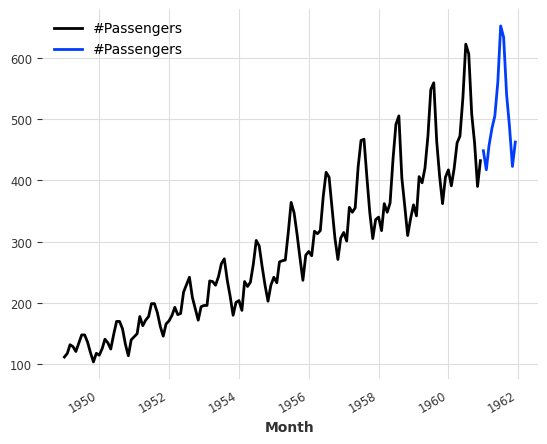

In [44]:
df_ts.plot()
pred.plot()
plt.show()